# **1. Import Libraries**

In [175]:
# Data Analysis
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import random
import warnings
from collections import Counter
plt.style.use('ggplot')
# Ignore warnings
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0, DenseNet121, ResNet50, VGG16, ResNet50
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2

# Sci-kit learn

## Model building
from sklearn.model_selection import train_test_split

## Metrics to evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

## Handle class imbalance
from sklearn.utils import class_weight

import pickle

In [176]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [177]:
# Directories
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "val")

In [178]:
# Allow reproducability
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# **2. Data Analysis**

## **2.1 Image Count Analysis**

In [179]:
# Count images in each category
data_counts = {}
for split in ['train', 'test', 'val']:
  split_dir = os.path.join(base_dir, split)
  data_counts[split] = {}

  for category in ['NORMAL', 'PNEUMONIA']:
    category_dir = os.path.join(split_dir, category)
    if os.path.exists(category_dir):
      num_images = len(os.listdir(category_dir))
      data_counts[split][category] = num_images
      print(f"{split} / {category}: {num_images} images")
    else:
      data_counts[split][category] = 0

train / NORMAL: 1342 images
train / PNEUMONIA: 3876 images
test / NORMAL: 234 images
test / PNEUMONIA: 390 images
val / NORMAL: 9 images
val / PNEUMONIA: 9 images


## **2.2 Class Distribution Analysis**

In [180]:
def view_class_distribution(data_counts):
  """
  Displays class distributions for a folder
  """
  plt.pie(data_counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%',
          colors=['#2ecc71', '#e74c3c'], startangle=90, explode=(0.05, 0))
  plt.title(f'Class Distribution (n = {sum(data_counts)})')
  plt.show()

In [181]:
# Get each counts for each folder
train_counts = [data_counts['train']['NORMAL'], data_counts['train']['PNEUMONIA']]
test_counts = [data_counts['test']['NORMAL'], data_counts['test']['PNEUMONIA']]
val_counts = [data_counts['val']['NORMAL'], data_counts['val']['PNEUMONIA']]

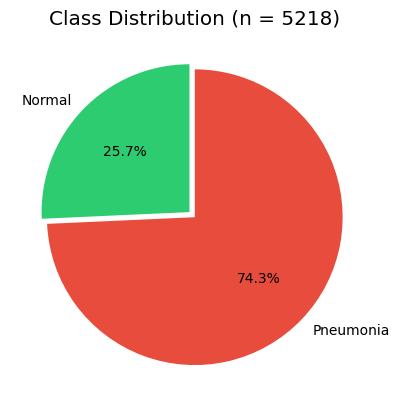

In [182]:
# Train distribution
view_class_distribution(train_counts)

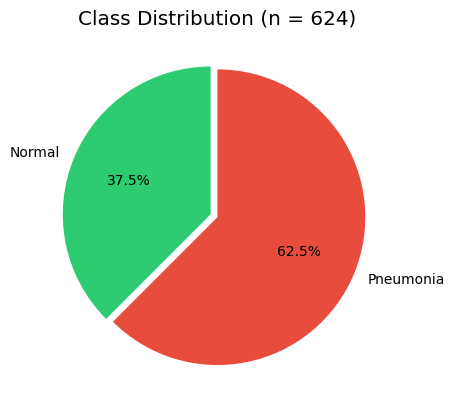

In [183]:
# Test distribution
view_class_distribution(test_counts)

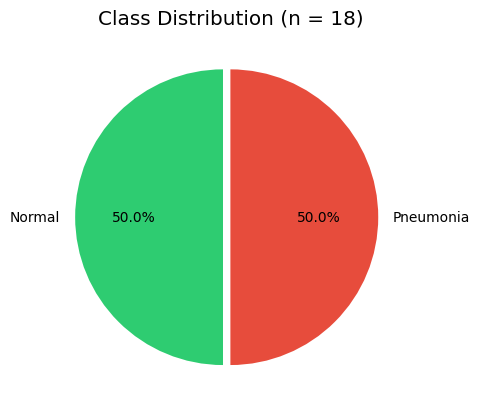

In [184]:
# Validation distribution
view_class_distribution(val_counts)

## **2.3 Imbalance Ratio Analysis**

In [185]:
# Divide pneumonia train counts with normal train counts
ratio = data_counts['train']['PNEUMONIA'] / data_counts['train']['NORMAL']
print(f"Class Imbalance Ratio: {ratio:.3f}")

Class Imbalance Ratio: 2.888


## **2.4 Image Analysis**

In [186]:
samples = []

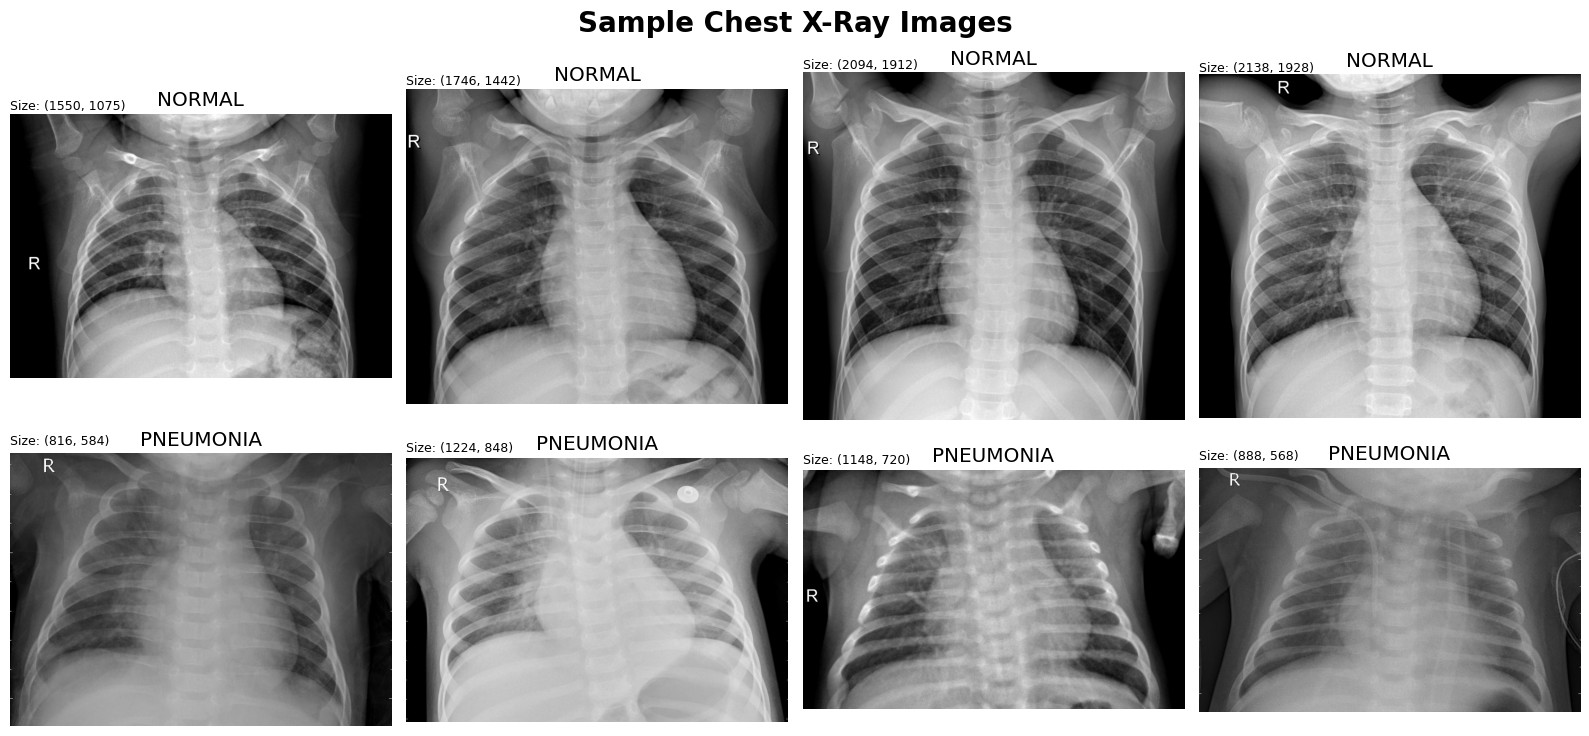

In [187]:
fig, axes = plt.subplots(2,4, figsize=(16,8))

for label in ['NORMAL', 'PNEUMONIA']:
  label_path = os.path.join(train_dir, label)
  img_files = [f for f in os.listdir(label_path) if f.endswith(('.jpeg', '.jpg'))]

  # Random 4 samples (filenames) for the current label
  selected_filenames = random.sample(img_files, 4)

  for img_file_name in selected_filenames:
    img_path = os.path.join(label_path, img_file_name)
    img = Image.open(img_path)
    samples.append((img, label))

# Display samples
for i, tup in enumerate(samples):
  row = i // 4
  col = i % 4

  axes[row, col].imshow(tup[0], cmap='gray')
  axes[row, col].set_title(tup[1])
  axes[row, col].axis('off')

  axes[row, col].text(0, -20, f'Size: {tup[0].size}', fontsize=9)

plt.suptitle('Sample Chest X-Ray Images', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## **2.5 Dimension Analysis**

In [188]:
# Prepare a dimensions array to store all dimensions
dimensions = []

# Append first 50 image dimensions per category
for category in ['NORMAL', 'PNEUMONIA']:
  category_dir = os.path.join(train_dir, category)
  image_files = [f for f in os.listdir(category_dir) if f.endswith(('.jpeg', '.jpg'))]

  # First 50 images
  for img_file in image_files[:50]:
    path = os.path.join(category_dir, img_file)
    img = Image.open(path)
    dimensions.append(img.size)

In [189]:
dimensions = np.array(dimensions)

In [190]:
dimensions

array([[1336, 1128],
       [1400, 1260],
       [1218, 1032],
       [1782, 1433],
       [1574, 1129],
       [1744, 1345],
       [1844, 1272],
       [1500, 1249],
       [2400, 2121],
       [1338, 1102],
       [1160,  904],
       [1804, 1510],
       [1488, 1017],
       [1636, 1329],
       [1802, 1422],
       [1932, 1908],
       [1580, 1410],
       [1576, 1272],
       [1542, 1461],
       [1472,  978],
       [1676, 1391],
       [1402, 1105],
       [1690, 1383],
       [1692, 1221],
       [2358, 1959],
       [1754, 1178],
       [1546, 1399],
       [1848, 1588],
       [2018, 1920],
       [1014,  846],
       [1894, 1688],
       [1790, 1600],
       [1272, 1048],
       [1696, 1298],
       [1704, 1341],
       [1630, 1353],
       [1732, 1662],
       [1700, 1271],
       [1690, 1334],
       [1186,  940],
       [1620, 1340],
       [1462, 1140],
       [1792, 1611],
       [1724, 1422],
       [1512, 1302],
       [1314, 1171],
       [1330, 1133],
       [1164,

In [191]:
# Unique dimensions
np.unique(dimensions)

array([ 457,  488,  504,  516,  544,  562,  568,  624,  632,  648,  656,
        672,  680,  703,  712,  717,  736,  744,  752,  768,  776,  808,
        824,  829,  832,  840,  846,  856,  880,  884,  895,  896,  904,
        920,  928,  940,  976,  978,  984, 1010, 1014, 1016, 1017, 1021,
       1024, 1032, 1044, 1048, 1072, 1080, 1084, 1094, 1102, 1105, 1112,
       1120, 1128, 1129, 1133, 1140, 1144, 1149, 1152, 1160, 1164, 1171,
       1176, 1178, 1184, 1186, 1208, 1218, 1221, 1240, 1248, 1249, 1256,
       1260, 1271, 1272, 1298, 1302, 1314, 1328, 1329, 1330, 1334, 1336,
       1338, 1340, 1341, 1345, 1353, 1368, 1376, 1380, 1381, 1383, 1391,
       1392, 1399, 1400, 1402, 1408, 1410, 1422, 1424, 1428, 1433, 1456,
       1461, 1462, 1472, 1488, 1500, 1510, 1512, 1518, 1528, 1542, 1546,
       1555, 1574, 1576, 1580, 1588, 1600, 1611, 1620, 1630, 1636, 1662,
       1676, 1688, 1690, 1692, 1696, 1700, 1704, 1724, 1732, 1744, 1754,
       1782, 1790, 1792, 1802, 1804, 1844, 1848, 18

In [192]:
# Maximum dimensions
np.max(dimensions, axis=0)

array([2400, 2121])

In [193]:
# Minimum dimension
np.min(dimensions, axis=0)

array([703, 457])

In [194]:
# Average
np.mean(dimensions, axis=0)

array([1407.31, 1092.98])

# **3. Data Preprocessing**

## **3.1 Preprocessing Function**

In [195]:
def preprocess(img):
  """
  Applies medical image specific preprocessing
  - CLAHE for contrast enhancement
  - Normalization
  - Grayscaling
  """
  # Conver to grayscale if RGB
  if img.ndim == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  else:
    img_gray = img

  # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) - enhances local contrast by dividing images into tiles
  # Performs hisotgram equalization for each tile
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img_enhanced = clahe.apply(img_gray.astype(np.uint8))

  # Normalize to [0, 1]
  img_normalized = img_enhanced.astype(np.float32) / 255.0

  if img_normalized.ndim == 2:
    img_normalized = np.stack([img_normalized] * 3, axis=-1)

  return img_normalized

## **3.2 What is CLAHE?**

It is an image preprocessing technique used to help improve the contrast of images (GeeksforGeeks, 2025)

The way it works:



1.   Division of Tiles: The image is split into small, non-overlapping tiles
2.   Local Histogram Calculation: A histogram is computed for each tile
3. Contrast Limiting: A clip limit is set, and if a histogram bin exceeds this limit, then excess pixels are redistributed to other bins, thus preventing noise amplification
4. Bilinear Interpolation: These contrast adjusted tiles are then stitched back together using bilinear interpolation for smooth transitions


**Bilinear interpolation will perform linear interpolation twice, on the x-direction then the y-direction. Useful for grid type data. It resizes images by calculating new pixel values using a weighted average of the four nearest pixels, hence making images smoother.**


## **3.3 Data Generators**

In [196]:
# Train data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [197]:
# val and test generators but no augmentation
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess
)

In [198]:
# Define target size and batch size
target_size = (224, 224)
batch_size = 32

In [199]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

# Valid generator
val_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [200]:
# View information
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Classes: {train_generator.class_indices}")

Training samples: 5216
Validation samples: 16
Test samples: 624
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


## **3.4 Class Imbalance Handling using Class Weights**

In [201]:
# Get class counts with the total number of samples
class_counts = Counter(train_generator.classes)
total_samples = sum(class_counts.values())

In [202]:
# Check for the class weights
class_weights = {}

for class_idx, count in class_counts.items():
  class_weights[class_idx] = total_samples / (len(class_counts) * count)

In [203]:
# Display them
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int32(1): 3875, np.int32(0): 1341})
Class weights: {np.int32(0): 1.9448173005219984, np.int32(1): 0.6730322580645162}


## **3.5 Visualize Augmented Samples**

In [204]:
# Prepare images + labels with class names
images, labels = next(train_generator)
class_names = {v: k for k, v in train_generator.class_indices.items()}

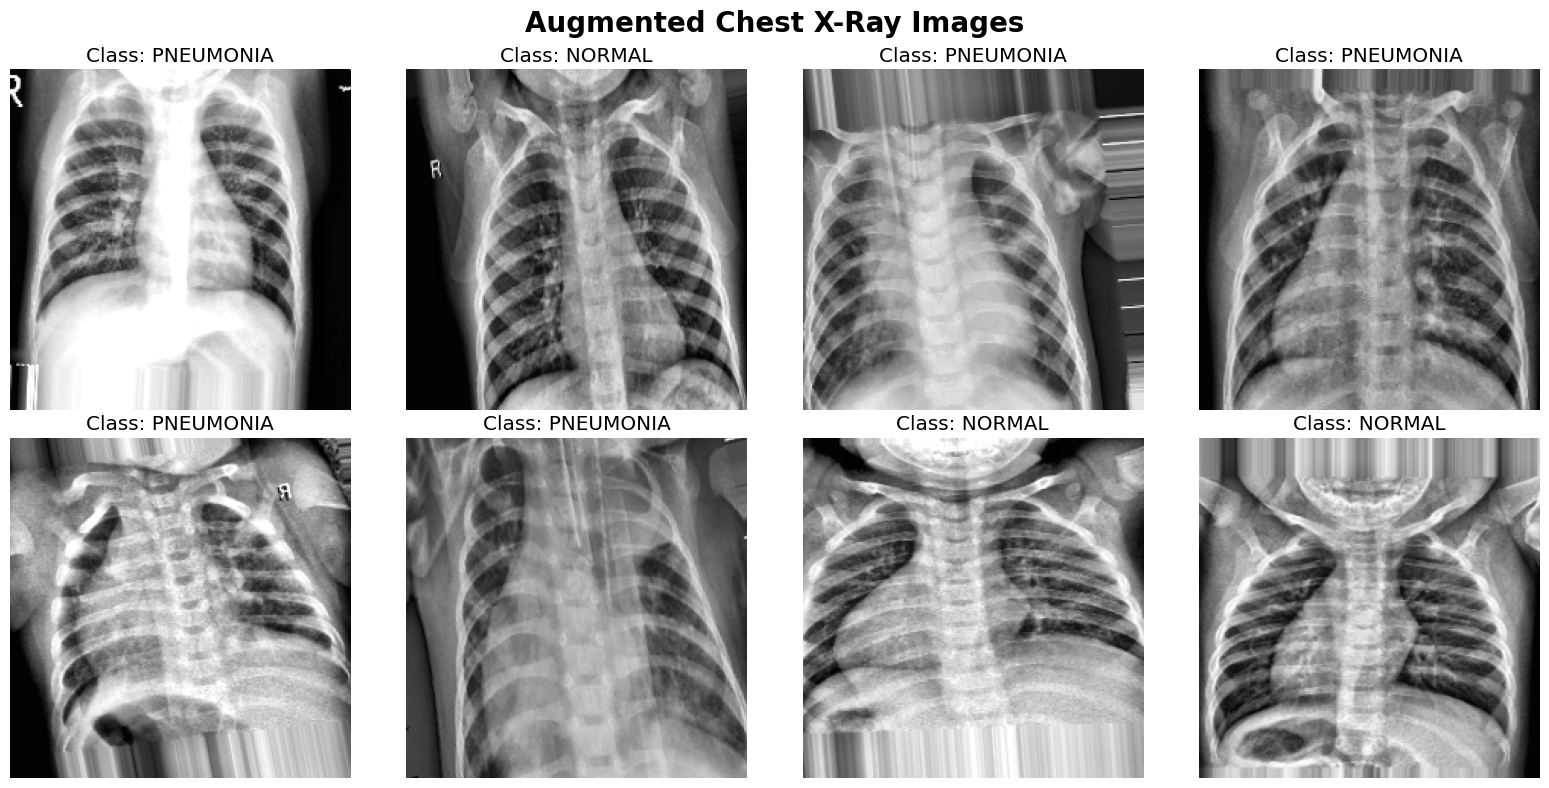

In [205]:
# Visualize the augmented samples
fig, axes = plt.subplots(2,4, figsize=(16,8))
for i in range(8):
  ax = axes[i//4, i%4]
  ax.imshow(images[i])
  ax.set_title(f"Class: {class_names[int(labels[i])]}")
  ax.axis('off')

plt.suptitle('Augmented Chest X-Ray Images', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# **4. Synthetic Data Generation**

In [206]:
# Synthetic data generator
synthetic_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=30.0,
    fill_mode='reflect'
)

In [207]:
# Synthetic train generator
synthetic_train_generator = synthetic_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


Augmentations done:



1.   Rotation by 20 degrees
2.   Width/Height shift by 15%
3. Shear by 15%
4. Zoom by 25%
5. Horizontal & Vertical flip
6. Brightness variation between 70% and 130%
7. Channel shift
8. CLAHE preprocessing done


In [208]:
# Demonstrating the synthetic data generation
sample_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_img = Image.open(sample_img_path).convert('RGB').resize(target_size)
sample_array = np.expand_dims(np.array(sample_img), axis=0)

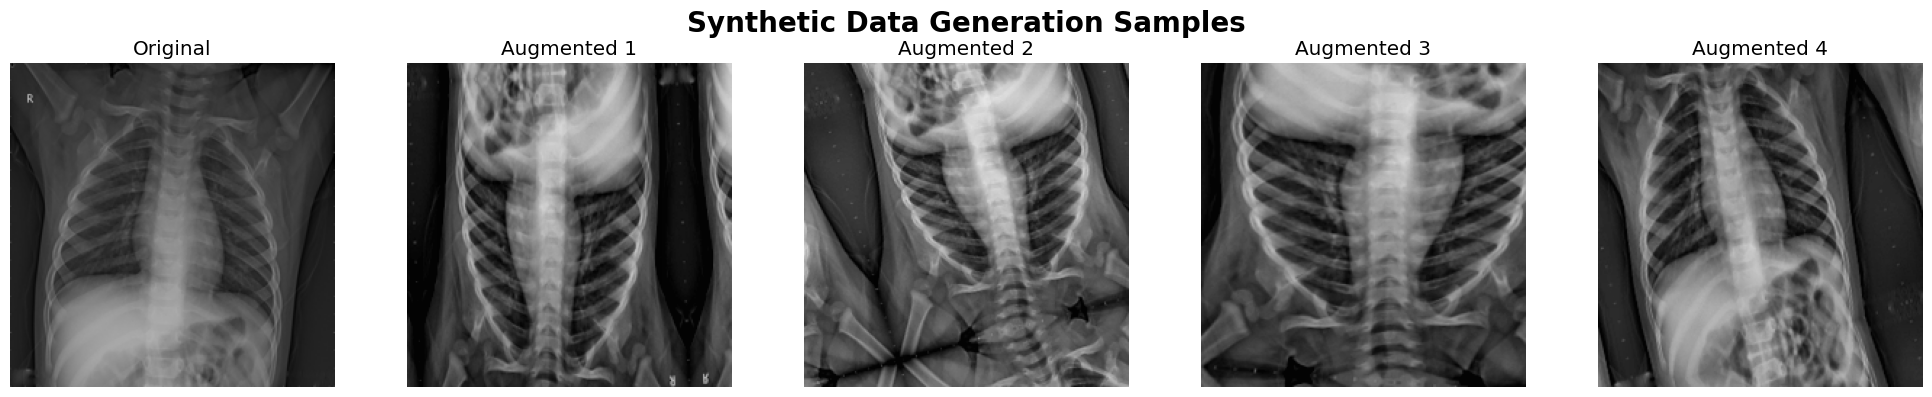

In [209]:
# Prepare for plotting
fig, axes = plt.subplots(1,5, figsize=(20,4))

# Show original
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Generate and show augmented versions
for i in range(4):
  for batch in synthetic_datagen.flow(sample_array, batch_size=1):
    augmented_img = (batch[0] * 255).astype('uint8')
    axes[i+1].imshow(augmented_img, cmap='gray')
    axes[i+1].set_title(f'Augmented {i+1}')
    axes[i+1].axis('off')
    break # would loop forever

plt.suptitle('Synthetic Data Generation Samples', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# **5. Model Building**

In [210]:
# Load pre-trained DenseNet121
densenet_base = DenseNet121(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3)
)

In [211]:
# Freeze base model layers
densenet_base.trainable = False

In [212]:
# Build model on top of it
densenet_model = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ]
)

In [213]:
# Compile the model
densenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

In [214]:
# Summary of the model
densenet_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,334,465 (27.98 MB)

 Trainable params: 296,193 (1.13 MB)

 Non-trainable params: 7,038,272 (26.85 MB)

# **6. Model Training**

## **6.1 Define Callbacks**

In [225]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

# Model checkpointing
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [226]:
# Get callbacks
callbacks = [early_stopping, model_checkpoint]

# **6.2 Train DenseNet121**

In [227]:
model_checkpoint_densenet = ModelCheckpoint(
    'best_densenet.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [228]:
densenet_callbacks = [early_stopping, model_checkpoint_densenet]

In [229]:
densenet_history = densenet_model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=densenet_callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7938 - auc_10: 0.9065 - loss: 0.4123 - precision_10: 0.9533 - recall_10: 0.7598

163/163 ━━━━━━━━━━━━━━━━━━━━ 1075s 6s/step - accuracy: 0.7941 - auc_10: 0.9067 - loss: 0.4116 - precision_10: 0.9534 - recall_10: 0.7603 - val_accuracy: 0.8750 - val_auc_10: 1.0000 - val_loss: 0.4832 - val_precision_10: 1.0000 - val_recall_10: 0.7500
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9121 - auc_10: 0.9706 - loss: 0.2250 - precision_10: 0.9740 - recall_10: 0.9057

163/163 ━━━━━━━━━━━━━━━━━━━━ 1048s 6s/step - accuracy: 0.9122 - auc_10: 0.9706 - loss: 0.2249 - precision_10: 0.9740 - recall_10: 0.9057 - val_accuracy: 0.8750 - val_auc_10: 0.9844 - val_loss: 0.2869 - val_precision_10: 1.0000 - val_recall_10: 0.7500
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9274 - auc_10: 0.9775 - loss: 0.1928 - precision_10: 0.9781 - recall_10: 0.9238

163/163 ━━━━━━━━━━━━━━━━━━━━ 1065s 7s/step - accuracy: 0.9273 - auc_10: 0.9775 - loss: 0.1928 - precision_10: 0.9780 - recall_10: 0.9238 - val_accuracy: 0.8750 - val_auc_10: 1.0000 - val_loss: 0.3389 - val_precision_10: 1.0000 - val_recall_10: 0.7500
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9275 - auc_10: 0.9787 - loss: 0.1841 - precision_10: 0.9793 - recall_10: 0.9234

163/163 ━━━━━━━━━━━━━━━━━━━━ 1047s 6s/step - accuracy: 0.9276 - auc_10: 0.9787 - loss: 0.1841 - precision_10: 0.9793 - recall_10: 0.9234 - val_accuracy: 0.9375 - val_auc_10: 0.9844 - val_loss: 0.1890 - val_precision_10: 1.0000 - val_recall_10: 0.8750
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9350 - auc_10: 0.9855 - loss: 0.1535 - precision_10: 0.9839 - recall_10: 0.9281

163/163 ━━━━━━━━━━━━━━━━━━━━ 1059s 6s/step - accuracy: 0.9349 - auc_10: 0.9855 - loss: 0.1536 - precision_10: 0.9839 - recall_10: 0.9281 - val_accuracy: 0.8750 - val_auc_10: 1.0000 - val_loss: 0.5129 - val_precision_10: 1.0000 - val_recall_10: 0.7500
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9309 - auc_10: 0.9807 - loss: 0.1789 - precision_10: 0.9757 - recall_10: 0.9292

163/163 ━━━━━━━━━━━━━━━━━━━━ 1035s 6s/step - accuracy: 0.9309 - auc_10: 0.9807 - loss: 0.1788 - precision_10: 0.9758 - recall_10: 0.9292 - val_accuracy: 0.8750 - val_auc_10: 0.9844 - val_loss: 0.2556 - val_precision_10: 1.0000 - val_recall_10: 0.7500
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9323 - auc_10: 0.9816 - loss: 0.1681 - precision_10: 0.9821 - recall_10: 0.9275

163/163 ━━━━━━━━━━━━━━━━━━━━ 1034s 6s/step - accuracy: 0.9324 - auc_10: 0.9816 - loss: 0.1680 - precision_10: 0.9821 - recall_10: 0.9275 - val_accuracy: 0.8750 - val_auc_10: 0.9844 - val_loss: 0.2567 - val_precision_10: 1.0000 - val_recall_10: 0.7500
Epoch 8/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9438 - auc_10: 0.9854 - loss: 0.1491 - precision_10: 0.9844 - recall_10: 0.9396

163/163 ━━━━━━━━━━━━━━━━━━━━ 1050s 6s/step - accuracy: 0.9438 - auc_10: 0.9854 - loss: 0.1491 - precision_10: 0.9844 - recall_10: 0.9396 - val_accuracy: 0.8125 - val_auc_10: 0.9844 - val_loss: 0.5631 - val_precision_10: 1.0000 - val_recall_10: 0.6250
Epoch 9/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9428 - auc_10: 0.9867 - loss: 0.1417 - precision_10: 0.9870 - recall_10: 0.9364

163/163 ━━━━━━━━━━━━━━━━━━━━ 1040s 6s/step - accuracy: 0.9428 - auc_10: 0.9867 - loss: 0.1417 - precision_10: 0.9870 - recall_10: 0.9364 - val_accuracy: 0.8750 - val_auc_10: 0.9844 - val_loss: 0.1802 - val_precision_10: 0.8750 - val_recall_10: 0.8750
Epoch 10/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9444 - auc_10: 0.9870 - loss: 0.1433 - precision_10: 0.9847 - recall_10: 0.9390

163/163 ━━━━━━━━━━━━━━━━━━━━ 1033s 6s/step - accuracy: 0.9444 - auc_10: 0.9870 - loss: 0.1433 - precision_10: 0.9847 - recall_10: 0.9390 - val_accuracy: 0.8125 - val_auc_10: 0.9688 - val_loss: 0.5631 - val_precision_10: 1.0000 - val_recall_10: 0.6250
Epoch 11/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9339 - auc_10: 0.9818 - loss: 0.1712 - precision_10: 0.9792 - recall_10: 0.9322

163/163 ━━━━━━━━━━━━━━━━━━━━ 1044s 6s/step - accuracy: 0.9339 - auc_10: 0.9819 - loss: 0.1710 - precision_10: 0.9792 - recall_10: 0.9323 - val_accuracy: 0.8750 - val_auc_10: 0.9844 - val_loss: 0.2254 - val_precision_10: 1.0000 - val_recall_10: 0.7500
Epoch 12/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9357 - auc_10: 0.9828 - loss: 0.1604 - precision_10: 0.9837 - recall_10: 0.9291

163/163 ━━━━━━━━━━━━━━━━━━━━ 1026s 6s/step - accuracy: 0.9357 - auc_10: 0.9828 - loss: 0.1604 - precision_10: 0.9837 - recall_10: 0.9291 - val_accuracy: 0.9375 - val_auc_10: 0.9844 - val_loss: 0.1634 - val_precision_10: 1.0000 - val_recall_10: 0.8750


In [ ]:
# Save history
with open('base.pkl', 'wb') as f:
  pickle.dump(densenet_history.history, f)

# **7. Model Evaluation**

In [249]:
def plot_curves(model, title):
  # Prepare plotting
  fig, axes = plt.subplots(2, 3, figsize=(18,10))

  plt.suptitle(f'History Metrics for {title}', fontweight='bold', fontsize=21)

  # Accuracy
  axes[0, 0].plot(model.history['accuracy'], label=f'Training Accuracy', c='r')
  axes[0, 0].plot(model.history['val_accuracy'], label=f'Validation Accuracy', c='b')
  axes[0, 0].set_title(f'{title} - Accuracy')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Accuracy')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # Loss
  axes[0, 1].plot(model.history['loss'], label='Training Loss', c='r')
  axes[0, 1].plot(model.history['val_loss'], label='Validation Loss', c='b')
  axes[0, 1].set_title(f'{title} - Loss')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Loss')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # Precision
  axes[0, 2].plot(model.history['precision_10'], label='Training Precision', c='r')
  axes[0, 2].plot(model.history['val_precision_10'], label='Validation Precision', c='b')
  axes[0, 2].set_title(f'{title} - Precision')
  axes[0, 2].set_xlabel('Epoch')
  axes[0, 2].set_ylabel('Precision')
  axes[0, 2].legend()
  axes[0, 2].grid(True, alpha=0.3)

  # Recall
  axes[1, 0].plot(model.history['recall_10'], label='Training Recall', c='r')
  axes[1, 0].plot(model.history['val_recall_10'], label='Validation Recall', c='b')
  axes[1, 0].set_title(f'{title} - Recall')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('Recall')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # AUC
  axes[1, 1].plot(model.history['auc_10'], label='Training AUC', c='r')
  axes[1, 1].plot(model.history['val_auc_10'], label='Validation AUC', c='b')
  axes[1, 1].set_title(f'{title} - AUC')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('AUC')
  axes[1, 1].legend()
  axes[1, 1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

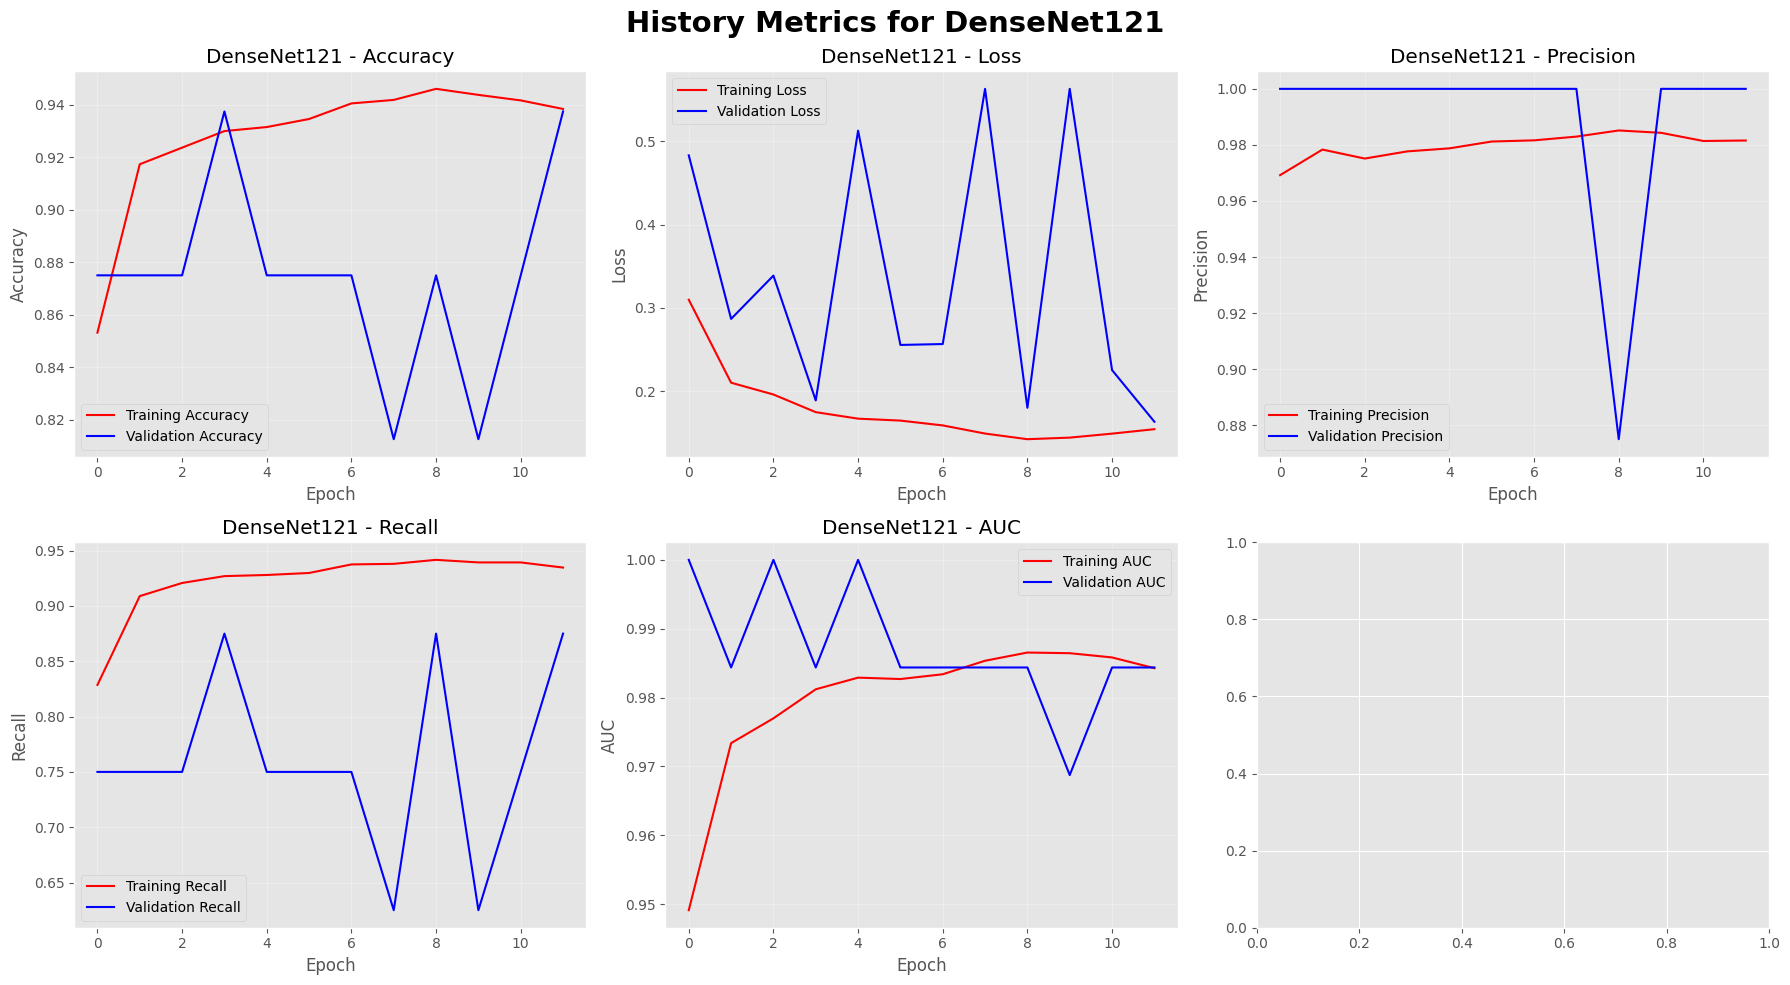

In [250]:
plot_curves(densenet_history, 'DenseNet121')

In [ ]:
# get best validation accuracies
best_val_acc = max(densenet_history.history['val_accuracy'])
best_val_loss = min(densnet_history.history['val_loss'])
best_val_precision = max(densenet_history.history['val_precision_10'])
best_val_recall = max(densenet_history.history['val_recall_10'])
best_val_auc = max(densenet_history.history['val_auc_10'])

In [ ]:
# All plotted metrics
metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']

In [ ]:
# Loop through the metrics
for metric in metrics:
  if metric in ["precision", "recall", "auc"]:
    print(f"Best Validation {metric.capitalize()}: {round(max(densenet_history.history[f'val_{metric}_10']), 4)}")
  elif metric == "loss":
    print(f"Best Validation {metric.capitalize()}: {round(min(densenet_history.history[f'val_{metric}']), 4)}")
  else:
    print(f"Best Validation {metric.capitalize()}: {round(max(densenet_history.history[f'val_{metric}']), 4)}")

In [ ]:
test_generator.reset()
base_test_results = densenet_model.evaluate(test_generator, verbose=1)
base_predictions = densenet_model.predict(test_generator, verbose=1)
base_pred_classes = (base_predictions > 0.5).astype(int)
base_pred_proba = base_predictions.flatten()

In [ ]:
# Get true labels
test_generator.reset()
y_true = test_generator.classes

In [ ]:
def get_metrics(y_true, y_pred, y_pred_proba, model_name):

  # Classification report
  report = classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'])

  # Confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

  # ROC AUC
  fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
  roc_auc = auc(fpr, tpr)

  metrics = {
      'model': model_name,
      'classification_report': report,
      'confusion_matrix': cm,
      'confusion_matrix_disp': disp,
      'roc_auc': roc_auc
  }

  return metrics

In [ ]:
base_metrics = get_metrics(y_true, base_pred_classes, base_pred_proba, 'DenseNet121')

In [ ]:
# View confusion matrix
base_metrics['confusion_matrix_disp'].plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Classification report
print(base_metrics['classification_report'])

In [ ]:
# ROC AUC
print("ROC AUC score:", base_metrics['roc_auc'])